In [12]:
import gym
import gym_jumping_task
from gym_jumping_task.envs.jumping_task import JumpTaskEnv
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid
from env import RandomAugmentingEnv

In [3]:
device = torch.device('cpu')

env = JumpTaskEnv(scr_w=60, scr_h=60)
observation = env._reset(floor_height=30, obstacle_position=30)
print(observation.shape)
observation

(60, 60)


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [ ]:
plt.imshow(np.flipud(observation), cmap='gray', vmin=0, vmax=1)

In [20]:
def show_imgs(x,max_display=16):
    grid = make_grid(torch.from_numpy(x[:max_display]),4).permute(1,2,0).cpu().numpy()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(grid)

### Environment Configurations

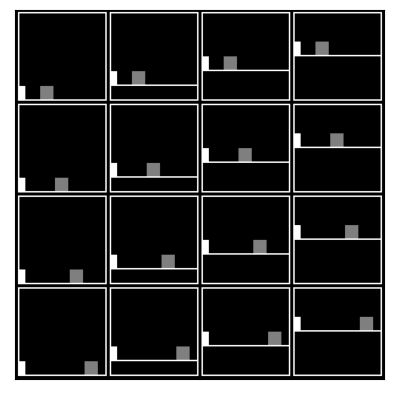

In [21]:
ALL_CONFIGURATIONS = [
     # obstacle pos, floor height
    (15, 0), (15, 10), (15, 20), (15, 30),  
    (25, 0), (25, 10), (25, 20), (25, 30), 
    (35, 0), (35, 10), (35, 20), (35, 30), 
    (45, 0), (45, 10), (45, 20), (45, 30), 
]

frames = []
for conf in ALL_CONFIGURATIONS:
    obs = env._reset(obstacle_position=conf[0], floor_height=conf[1] )
    frames.append(np.flipud(obs))
    
show_imgs(np.expand_dims(np.array(np.array(frames) * 255, dtype=np.uint8), axis=1))

In [23]:
env = JumpTaskEnv(scr_w=60, scr_h=60, rendering=True, slow_motion=True)

def watch_agent(env, agent=None):
    state = env.reset()
    cumreward = 0
    for _ in range(200):
        env.render()
        if agent is None:
            action = env.action_space.sample()
        else:
            action, _ = agent.act(state)
            action = action.numpy()
        state, reward, done, info = env.step(action)
        cumreward += reward

        if done:
            print("Cumulative reward: ", cumreward)
            cumreward = 0
            env.reset()
    env.close()

watch_agent(env)
    

Cumulative reward:  24
Cumulative reward:  24
Cumulative reward:  34
Cumulative reward:  23
Cumulative reward:  34
Cumulative reward:  24


In [16]:
# vectorized env
env = gym.vector.SyncVectorEnv([
    lambda: RandomAugmentingEnv(obs_position=20, floor_height=20),
    lambda: RandomAugmentingEnv(obs_position=20, floor_height=20),
    lambda: RandomAugmentingEnv(obs_position=20, floor_height=20)
])
obs = env.reset()
np.array(obs).shape

(3, 1, 60, 60)